<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transformers/Attention_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention and Transfromers

## Imports

In [ ]:
%%capture
!pip install googletrans==4.0.0-rc1

In [2]:
import copy
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from googletrans import Translator
from google.colab import files
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertTokenizerFast
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

from wordcloud import WordCloud

## Data preparation

### Download data

In [3]:
%%capture
!wget https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Transformers/data/data_problems.xlsx
!wget https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Transformers/data/math_rus_processed.xlsx -O processed.xlsx
!wget https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Transformers/data/math_translation.xlsx -O translation.xlsx

### Load data

In [58]:
dataset = pd.read_excel('data_problems.xlsx')

In [59]:
df_0 = dataset.drop(columns=['Unnamed: 0'])
df_0 = df_0.rename(columns={'Тема': 'Topic', 'Задача': 'Text'})

In [ ]:
df_0.sample(10)

Text         Topic
4780  а) Есть 128 монет двух различных весов, монет ...     Инвариант
2883  Требуется записать число вида 7...7, используя...  Теория чисел
2242  Подряд без пробелов выписали все чётные числа ...  Теория чисел
119   В городе одна синяя площадь и n зелёных, причё...         Графы
2762  Доказать, что если длины сторон прямоугольного...  Теория чисел
4097  Каждую букву исходного сообщения заменили её д...  Теория чисел
4463  Даны два многочлена от переменной x с целыми к...  Теория чисел
3396  Доказать, что в любой бесконечной арифметическ...  Теория чисел
4214  Из чисел от 1 до 2n выбрано  n + 1  число. Док...  Теория чисел
4352  Найдите наименьшее натуральное число, представ...  Теория чисел

In [ ]:
df_0.describe()

Text         Topic
count   5273          5273
unique  4350             7
top           Теория чисел
freq       7          2396

In [ ]:
df_0["Topic"].unique()

array(['Графы', 'Геометрия', 'Многочлен', 'Комбинаторика', 'Теория чисел',
       'Инвариант', 'Дирихле'], dtype=object)

In [ ]:
df_0['Topic'].value_counts()

Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: Topic, dtype: int64

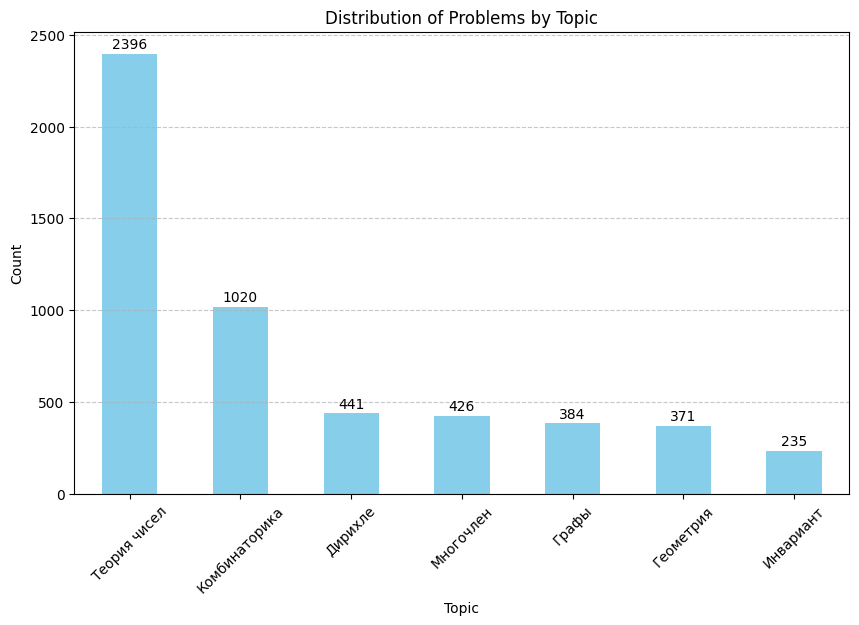

In [48]:
topics_counts = df_0['Topic'].value_counts()

plt.figure(figsize=(10, 6))
topics_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Problems by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(topics_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

In [29]:
dfdict = {'Графы': 0, 'Геометрия': 1, 'Многочлен': 2, 'Комбинаторика': 3, 'Теория чисел': 4,
       'Инвариант': 5, 'Дирихле': 6}
df_1 = df_0.copy()
df_1['Topic'] = df_0['Topic'].replace(dfdict)
df_1["Topic"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [145]:
def print_duplicates(df, col='Text'):
    topic_counts = df['Topic'].value_counts()
    unique_df = df.drop_duplicates(subset=[col], keep='first')
    unique_topic_counts = unique_df['Topic'].value_counts()
    duplicate_counts = topic_counts - unique_topic_counts

    print("Topic\t\tSamples\tDuplicates")
    print("--------------------------------")
    for topic, samples in topic_counts.items():
        print(f"{topic}\t\t{samples}\t{duplicate_counts.get(topic, 0)}")

In [144]:
print_duplicates(df_0)

Topic		Samples	Duplicates
--------------------------------
Теория чисел		2396	244
Комбинаторика		1020	378
Дирихле		441	180
Многочлен		426	4
Графы		384	0
Геометрия		371	1
Инвариант		235	116


In [152]:
def show_duplicates(df, col ='Text'):
  print_duplicates(df, col)
  plt.figure(figsize=(12, 6))

  sorted_topics_counts = df['Topic'].value_counts().sort_values(ascending=False)
  df_u = df.drop_duplicates(subset=[col], keep='first')
  u_topic_counts = df_u['Topic'].value_counts()
  sorted_u_topic_counts = u_topic_counts.reindex(sorted_topics_counts.index, fill_value=0)
  number_of_duplicates = sorted_topics_counts - sorted_u_topic_counts

  for i, count in enumerate(sorted_topics_counts):
      plt.bar(i, count, color='skyblue', label='Original Data' if i == 0 else None, alpha=0.4, width=0.9)
      plt.text(i, count+50, str(count), ha='center', va='bottom', fontsize=8, color='darkblue')

  for i, u_count in enumerate(sorted_u_topic_counts):
      plt.bar(i+0.05, u_count, bottom=0, color='lightgreen', label='Unique values' if i == 0 else None, alpha=0.7)
      plt.text(i+0.05, u_count, str(u_count), ha='center', va='bottom', fontsize=8, color = 'green')

  for i, dup_count in enumerate(number_of_duplicates):
      plt.bar(i-0.05, dup_count, color='tomato', label='Duplicates' if i == 0 else None, alpha=0.7, width=0.9)
      plt.text(i-0.05 , dup_count, str(dup_count), ha='center', va='bottom', fontsize=8, color = 'crimson')

  plt.xticks(ticks=range(len(sorted_topics_counts)), labels=sorted_topics_counts.index, rotation=45)
  plt.title('Distribution of Problems by Topic of ' + col)
  plt.xlabel('Topic')
  plt.ylabel('Count')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.legend()
  plt.tight_layout()
  plt.show()

Topic		Samples	Duplicates
--------------------------------
Теория чисел		2396	244
Комбинаторика		1020	378
Дирихле		441	180
Многочлен		426	4
Графы		384	0
Геометрия		371	1
Инвариант		235	116


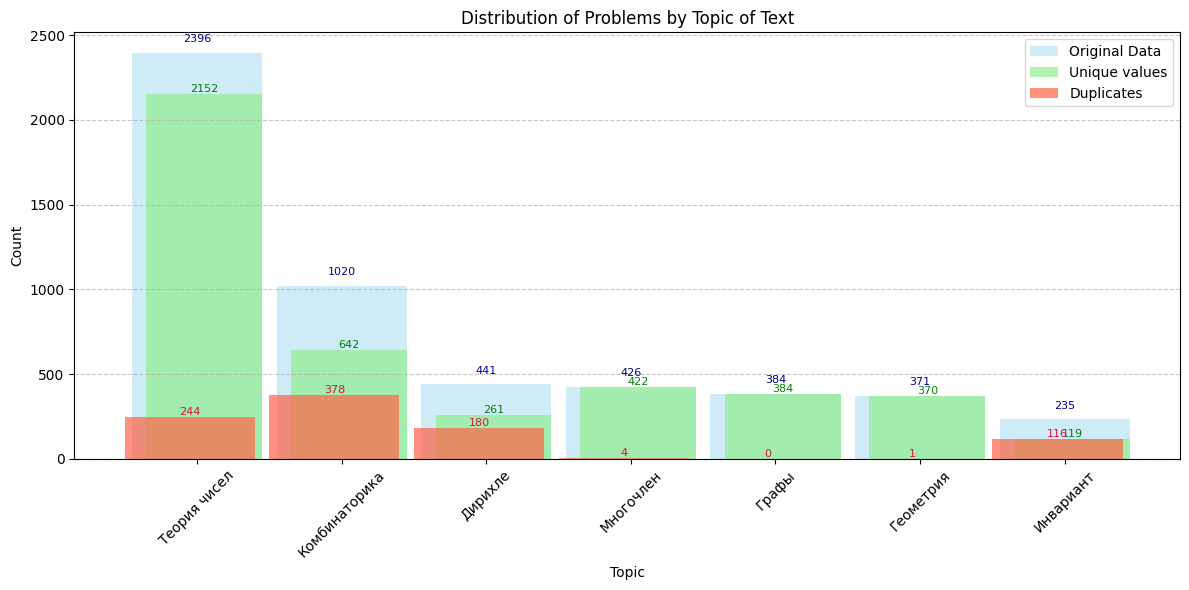

In [153]:
show_duplicates(df_0)

In [78]:
df_2 = df_0.copy()
df_2['Text Length'] = df_2['Text'].apply(lambda x: len(str(x)))

<ipython-input-64-d3b538cbbea4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_2['Topic'].unique(), rotation=45)


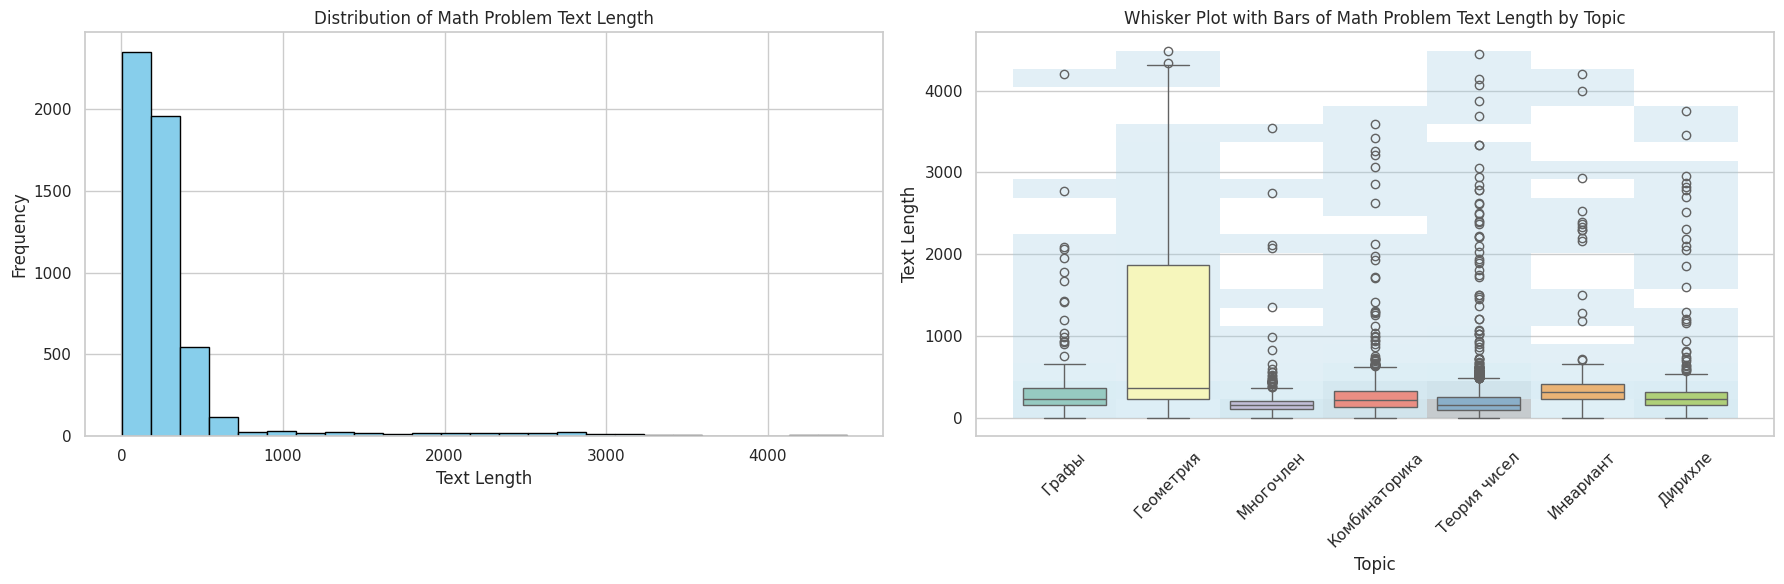

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of text lengths
axes[0].hist(df_2['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the whisker plot with bars
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_2, hue='Topic', palette='Set3')
sns.histplot(ax=axes[1], x='Topic', y='Text Length', data=df_2, color='skyblue', bins=20, kde=False, alpha=0.3)
axes[1].set_title('Whisker Plot with Bars of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_2['Topic'].unique(), rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-79-39271842d2c9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_filtered['Topic'].unique(), rotation=45)


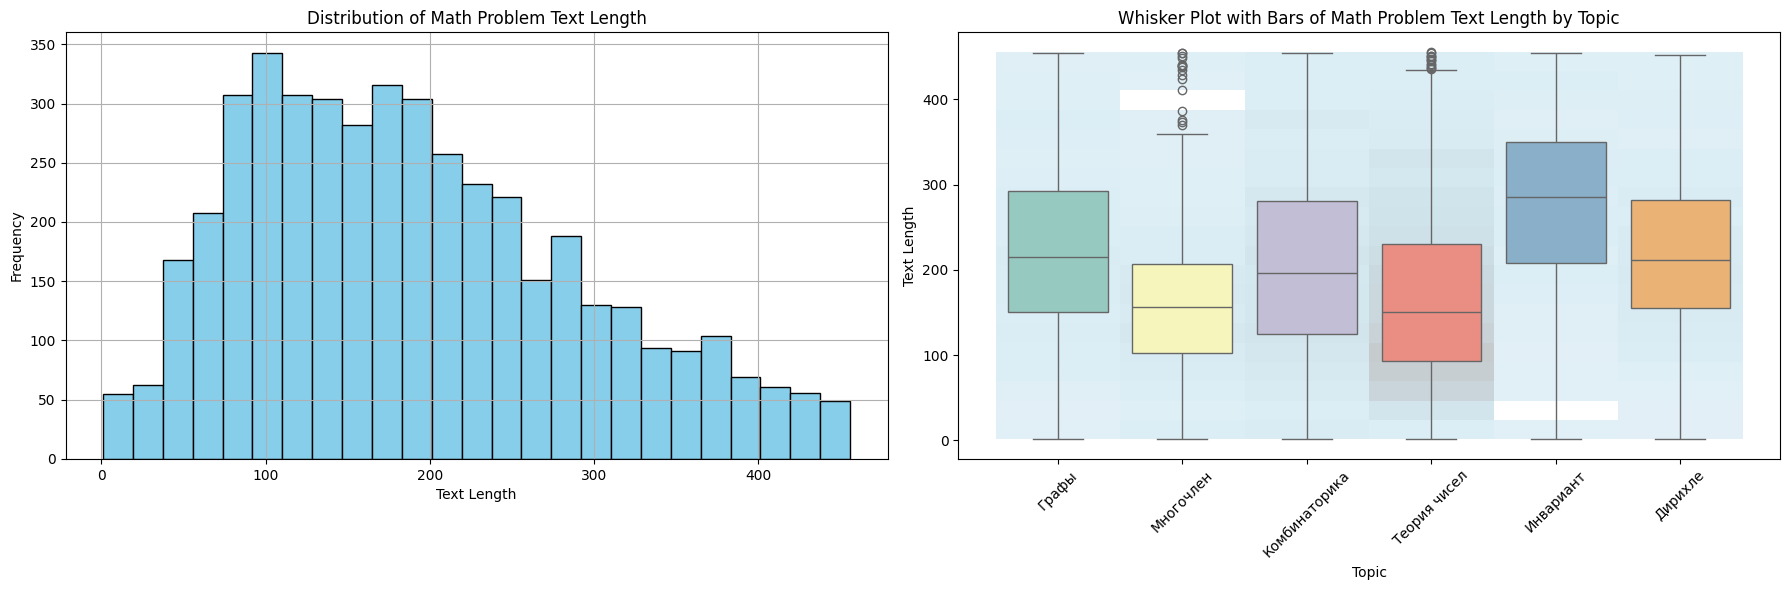

In [79]:
df_filtered = df_2[(df_2['Text Length'] <= df_2['Text Length'].quantile(0.75) * 1.5) &
                   (df_2['Topic'] != 'Геометрия')]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of text lengths
axes[0].hist(df_filtered['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the whisker plot with bars
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_filtered, hue='Topic', palette='Set3')
sns.histplot(ax=axes[1], x='Topic', y='Text Length', data=df_filtered, color='skyblue', bins=20, kde=False, alpha=0.3)
axes[1].set_title('Whisker Plot with Bars of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_filtered['Topic'].unique(), rotation=45)

plt.tight_layout()
plt.show()

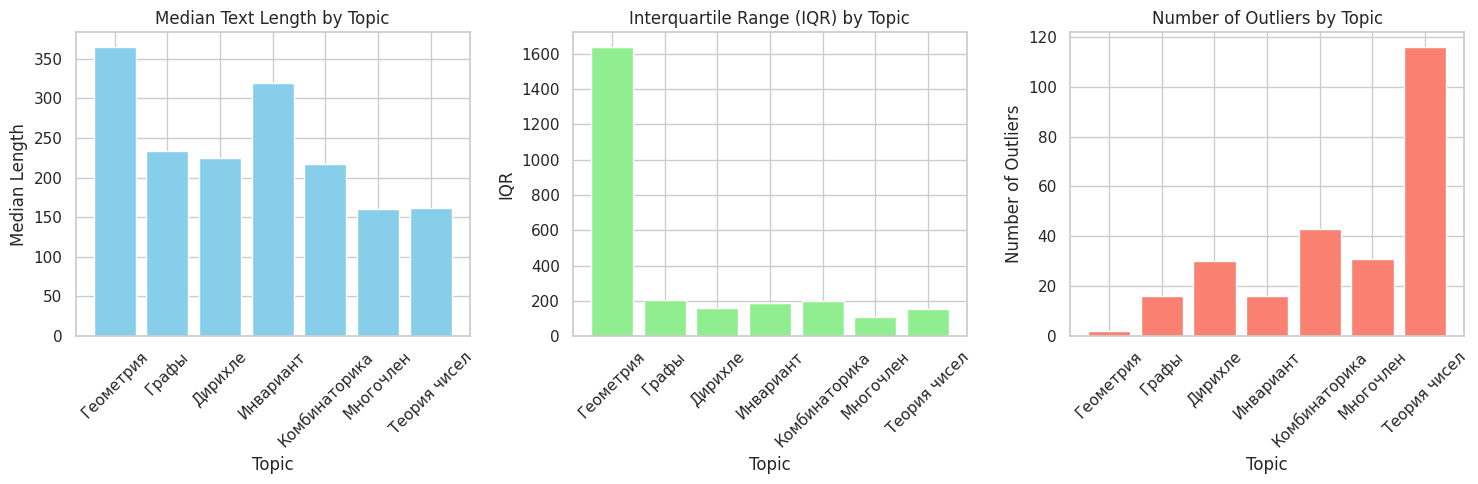

In [ ]:
grouped_df = df_2.groupby('Topic')
median_lengths, outlier_counts, IQRs  = {}, {}, {}

for topic, group_df in grouped_df:
    # Calculate median length
    median_length = group_df['Text Length'].median()
    median_lengths[topic] = median_length

    # Calculate IQR
    Q1 = group_df['Text Length'].quantile(0.25)
    Q3 = group_df['Text Length'].quantile(0.75)
    IQR = Q3 - Q1
    IQRs[topic] = IQR

    # Calculate outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group_df[(group_df['Text Length'] < lower_bound) | (group_df['Text Length'] > upper_bound)]
    outlier_counts[topic] = len(outliers)


median_lengths_df = pd.DataFrame(list(median_lengths.items()), columns=['Topic', 'Median Length'])
IQRs_df = pd.DataFrame(list(IQRs.items()), columns=['Topic', 'IQR'])
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Topic', 'Outliers'])
stats_df = median_lengths_df.merge(IQRs_df, on='Topic').merge(outlier_counts_df, on='Topic')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Median length
axes[0].bar(stats_df['Topic'], stats_df['Median Length'], color='skyblue')
axes[0].set_title('Median Text Length by Topic')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Median Length')
axes[0].tick_params(axis='x', rotation=45)

# IQR
axes[1].bar(stats_df['Topic'], stats_df['IQR'], color='lightgreen')
axes[1].set_title('Interquartile Range (IQR) by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('IQR')
axes[1].tick_params(axis='x', rotation=45)

# Outliers
axes[2].bar(stats_df['Topic'], stats_df['Outliers'], color='salmon')
axes[2].set_title('Number of Outliers by Topic')
axes[2].set_xlabel('Topic')
axes[2].set_ylabel('Number of Outliers')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As it is shown, we'll need to cut the outliers. Especially geometry. Since max median text length is ~350. We could Set it to 400

In [ ]:
geometry_samples = df_2[df_2['Topic'] == 'Геометрия'].sample(5)

for index, row in geometry_samples.iterrows():
    print("Length:", len(row['Text']))
    print("Text:", row['Text'])
    print()

Length: 191
Text: Треугольник ABC вписан в окружность с центром O. Прямые AC и BC вторично пересекают окружность, проходящую через точки A, O и B, в точках E и K. Докажите, что прямые OC и EK перпендикулярны. 

Length: 1475
Text: 
В треугольнике ABC угол C — тупой. На стороне AB отмечены
точки E и H, на сторонах AC и BC — точки K и M соответственно.
Оказалось, что AH = AC, BE = BC, AE = AK, BH = BM. Докажите, что
точки E, H, K, M лежат на одной окружности.














					Прислать комментарий
				



			   
			
				Решение
			










					Задача
					
						108171







						Темы:
						 
					

						[
					



								Четыре точки, лежащие на одной окружности							



						]
					



						[
					



								Три точки, лежащие на одной прямой							



						]
					



						[
					



								Углы, опирающиеся на равные дуги и равные хорды							



						]
					



						[
					



								Вписанные четырехугольники							



						]
					



						[
					



								Три 

In [ ]:
text_contains_comment = df_2[df_2['Text'].str.contains('Прислать комментарий')]
num_texts_with_comment = len(text_contains_comment)
print("Number of texts containing 'Прислать комментарий':", num_texts_with_comment)
average_length = text_contains_comment['Text'].apply(len).mean()
print("Average length:", average_length)

Number of texts containing 'Прислать комментарий': 323
Average length: 1849.6934984520124


In [ ]:
topics_for_comment_text = text_contains_comment[text_contains_comment['Text'].str.contains('Прислать комментарий', case=False)]['Topic']
print(topics_for_comment_text.unique())


['Графы' 'Геометрия' 'Многочлен' 'Комбинаторика' 'Теория чисел'
 'Инвариант' 'Дирихле']


<ipython-input-104-448800f9697b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Text Length'] = df_3['Text'].apply(lambda x: len(str(x)))
<ipython-input-104-448800f9697b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_3['Topic'].unique(), rotation=45)


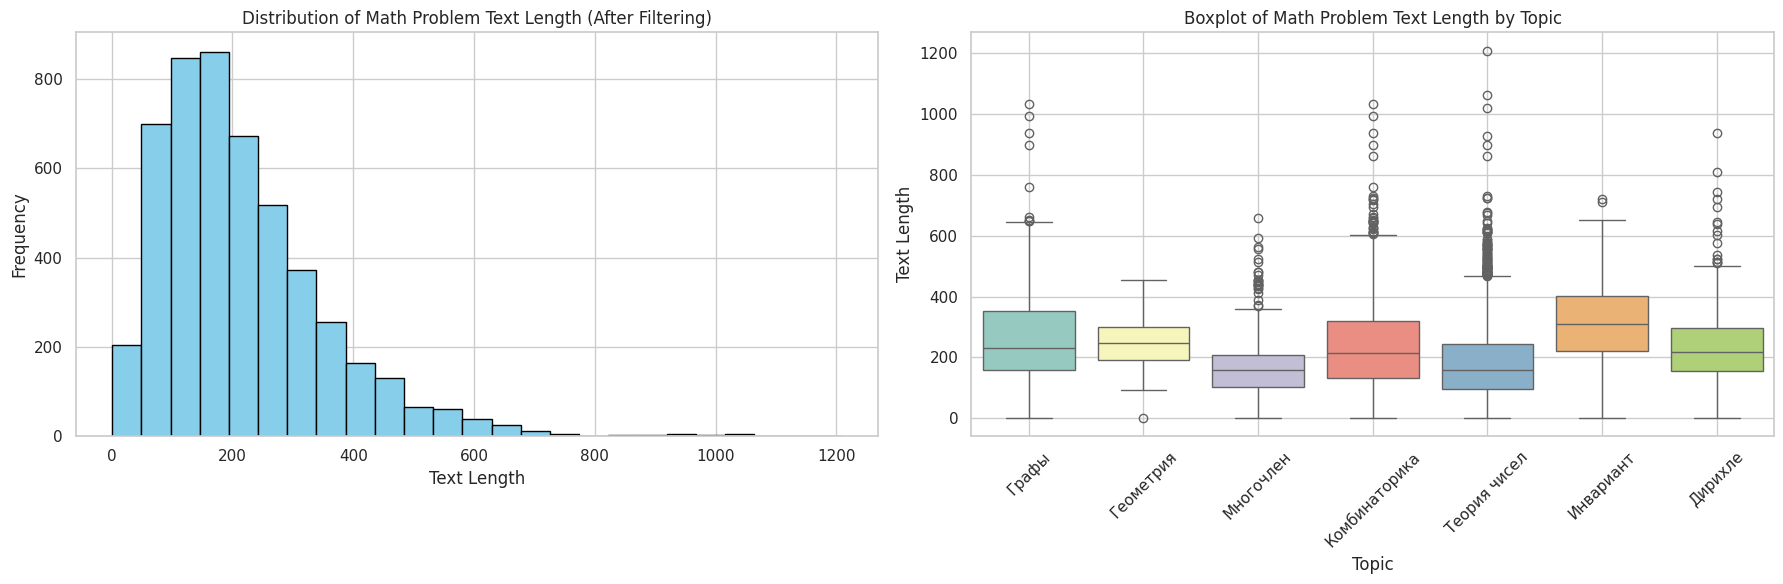

In [ ]:
df_3 = df_2[~df_2['Text'].str.contains("Прислать комментарий")]
df_3['Text Length'] = df_3['Text'].apply(lambda x: len(str(x)))

topic_stats = df_3.groupby('Topic').describe()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram
axes[0].hist(df_3['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length (After Filtering)')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot boxplot
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_3, hue='Topic', palette='Set3', showfliers=True)
axes[1].set_title('Boxplot of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_3['Topic'].unique(), rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
short_texts = df_3[df_3['Text Length'] < 60]
print(short_texts)

                                                   Text         Topic  \
26                                                              Графы   
138                 В некотором государстве 101 город.          Графы   
198                                                  \n         Графы   
276   б) Тот же вопрос для решётки 5×5 (всего 36 узл...         Графы   
284   б) Тот же вопрос для решётки 7×7 (всего 64 узл...         Графы   
...                                                 ...           ...   
4485  Решить в целых числах уравнение  x² + y² + z² ...  Теория чисел   
4622                              См. задачу 73546 а).      Инвариант   
4762                                                        Инвариант   
5060                В некотором государстве 101 город.        Дирихле   
5254                                                          Дирихле   

      Text Length  
26              1  
138            35  
198             1  
276            51  
284            50  
...

#### Trim values

We'll remove all entries that have "Прислать комментарий" since they are just wrongly parsed data as well as those that are shorter than 50 symbols.

In [81]:
df_4 = df_2[~df_2['Text'].str.contains("Прислать комментарий") & (df_2['Text Length'] >= 50)]

<ipython-input-142-9ce1da20c4bb>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


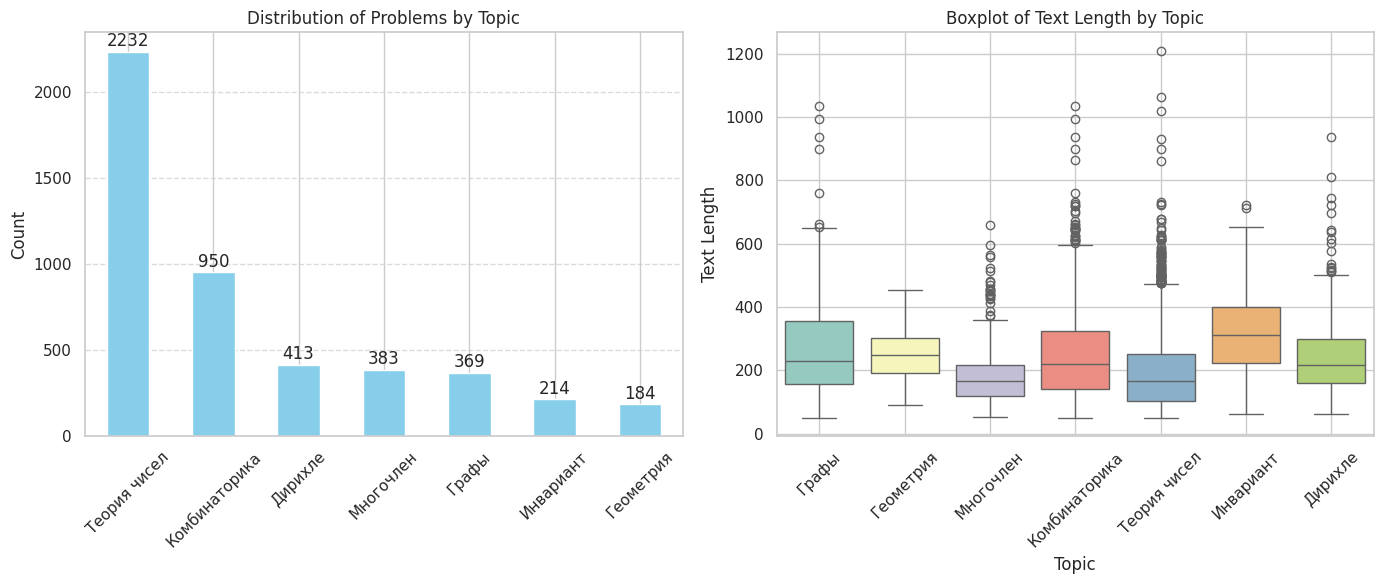

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
topics_counts = df_4['Topic'].value_counts()
topics_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Problems by Topic')
ax1.set_ylabel('Count')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
for i, count in enumerate(topics_counts):
    ax1.text(i, count + 10, str(count), ha='center', va='bottom')

# Box plot
sns.boxplot(x='Topic', y='Text Length', data=df_4, ax=ax2, hue='Topic', palette='Set3')
ax2.set_title('Boxplot of Text Length by Topic')
ax2.set_xlabel('Topic')
ax2.set_ylabel('Text Length')
ax2.grid(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## Tokenize

### Create tokenizer

In [82]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [83]:
def tokenize_text(text, pad=False):
  if pad:
    tokens = tokenizer.tokenize(text,  padding='max_length', truncation=True, max_length=128, return_tensors='pt')
  else:
    tokens = tokenizer.tokenize(text)
  return " ".join(tokens)

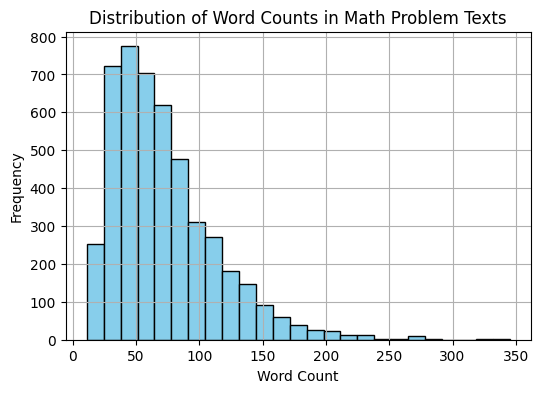

count    4745.000000
mean       72.009694
std        41.899225
min        11.000000
25%        41.000000
50%        63.000000
75%        92.000000
max       345.000000
Name: Token_Count, dtype: float64
П ##ет ##я сл ##о ##жил 10 после ##дова ##тельных степеней д ##вой ##ки , начиная с не ##кото ##рой , а В ##ася сл ##о ##жил некоторое количество после ##дова ##тельных на ##тура ##льных чисел , начиная с 1 . М ##ог ##ли ли они получить один и тот же результат ?

К ##оля , Се ##р ##ё ##жа и Ван ##я регулярно ход ##или в кино ##те ##атр . К ##оля бы ##вал в нём каждый третий день , Се ##р ##ё ##жа [UNK] каждый се ##дь ##мой , Ван ##я [UNK] каждый п ##ят ##ый . Се ##го ##дня все р ##еб ##ята были в кино . Когда все т ##рое в ##стр ##ет ##ятся в кино ##те ##атр ##е в следующий раз ?

До ##ка ##жит ##е , что у ##рав ##нение l ##² + m² = n ##² + 3 имеет б ##ес ##кон ##ечно много р ##еше ##ний в на ##тура ##льных числа ##х .

В турнире участвовал ##о 11 ша ##х ##мати ##стов : 4 [UNK] из России

In [84]:
df_5=df_4.copy()
df_5['Tokenized_Text'] = df_5['Text'].apply(tokenize_text)
df_5['Token_Count'] = df_5['Tokenized_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
plt.hist(df_5['Token_Count'], bins=25, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Math Problem Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_5['Token_Count'].describe())
sample_tokenized_text = df_5['Tokenized_Text'].sample(5)
for text in sample_tokenized_text:
    print(text)
    print()

Not actually what we want since we need padding after all

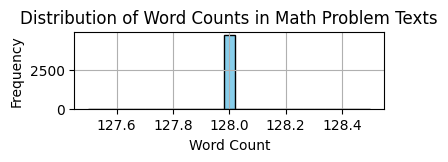

count    4745.0
mean      128.0
std         0.0
min       128.0
25%       128.0
50%       128.0
75%       128.0
max       128.0
Name: Token_Count, dtype: float64
а ) В класс ##е была дана контроль ##ная . Из ##вестно , что по крайне ##й мере ⅔ задач этой контроль ##ной оказались труд ##ными : ка ##ж ##ду ##ю так ##ую задач ##у не решил ##и по крайне ##й мере ⅔ школ ##ь ##ников . Из ##вестно также , что по крайне ##й мере ⅔ школ ##ь ##ников класса написал ##и контроль ##ную хорошо : каждый такой школ ##ь ##ник решил по крайне ##й мере ⅔ задач контроль ##ной . М ##ог ##ло ли такое быть ? [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Су ##ществ ##уют ли шесть таких после ##дова ##тельных на ##тура ##льных чисел , что на ##име ##нь ##шее об ##щее к ##ратно ##е первых трёх из них больше , чем на ##име ##н

In [85]:
df_6=df_4.copy()
df_6['Tokenized_Text'] = df_6['Text'].apply(lambda x: tokenize_text(x, True))
df_6['Token_Count'] = df_6['Tokenized_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(4, 1))
plt.hist(df_6['Token_Count'], bins=25, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Math Problem Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_6['Token_Count'].describe())
sample_tokenized_text = df_6['Tokenized_Text'].sample(5)
for text in sample_tokenized_text:
    print(text)
    print()

## Drop duplicates

Topic		Samples	Duplicates
--------------------------------
Теория чисел		2232	228
Комбинаторика		950	373
Дирихле		413	178
Многочлен		383	3
Графы		369	0
Инвариант		214	114
Геометрия		184	0


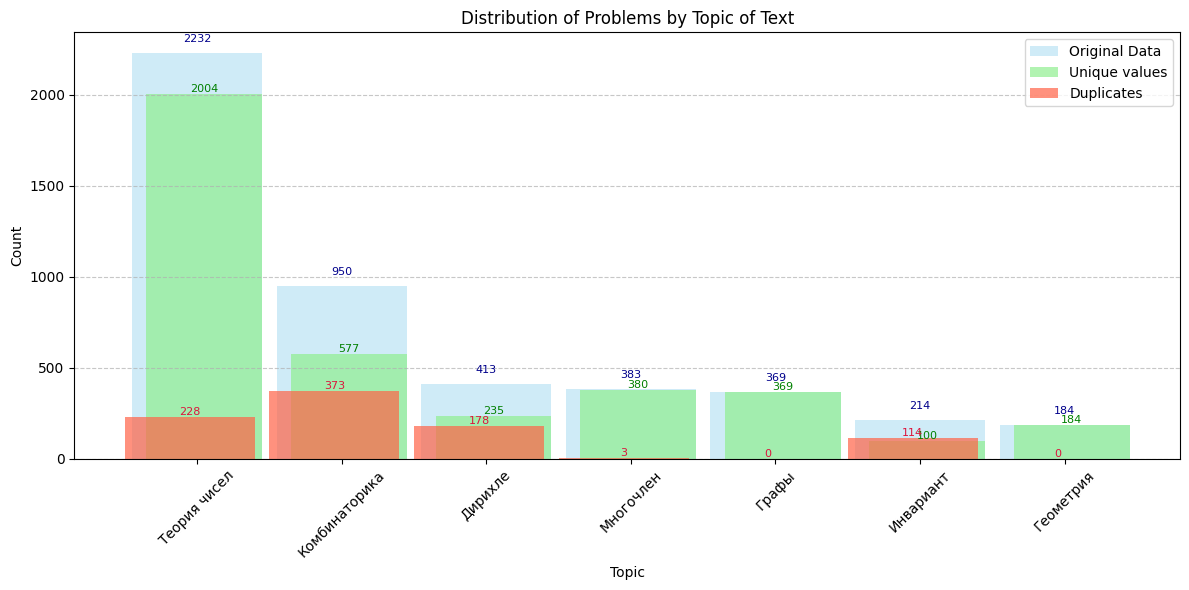

Topic		Samples	Duplicates
--------------------------------
Теория чисел		2232	229
Комбинаторика		950	374
Дирихле		413	178
Многочлен		383	3
Графы		369	0
Инвариант		214	114
Геометрия		184	1


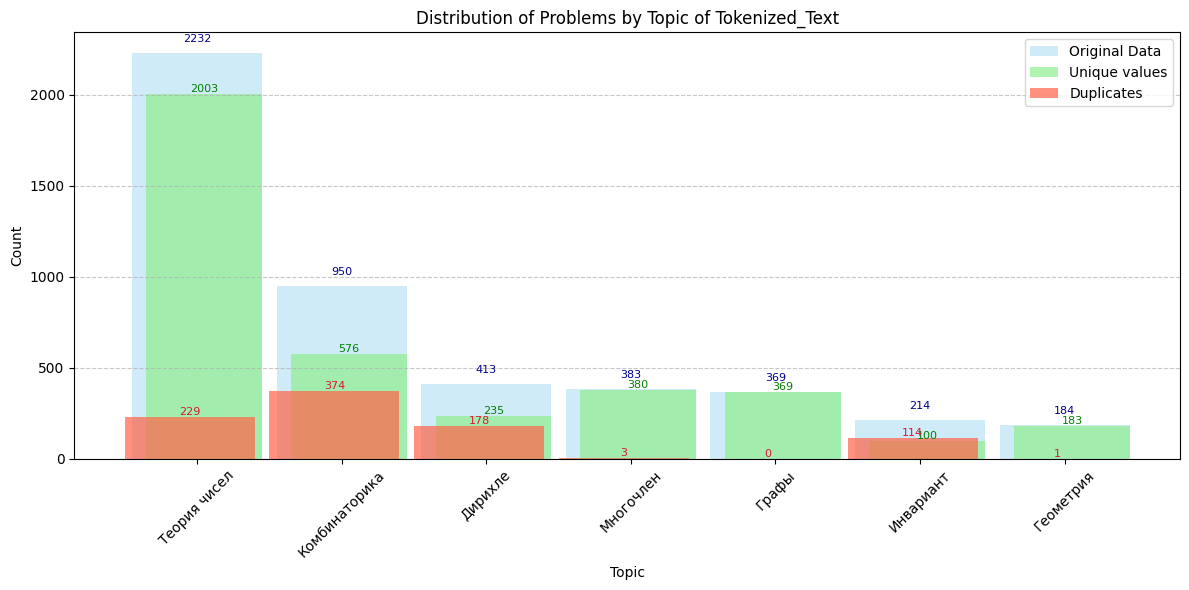

In [154]:
show_duplicates(df_6)
show_duplicates(df_6, 'Tokenized_Text')

In [ ]:
df_7 = df_6.copy()
df_7 = df_6.drop_duplicates(subset=['Text'], keep='first') # Since we could retokenize, so we choose Text

### Word frequency analysis

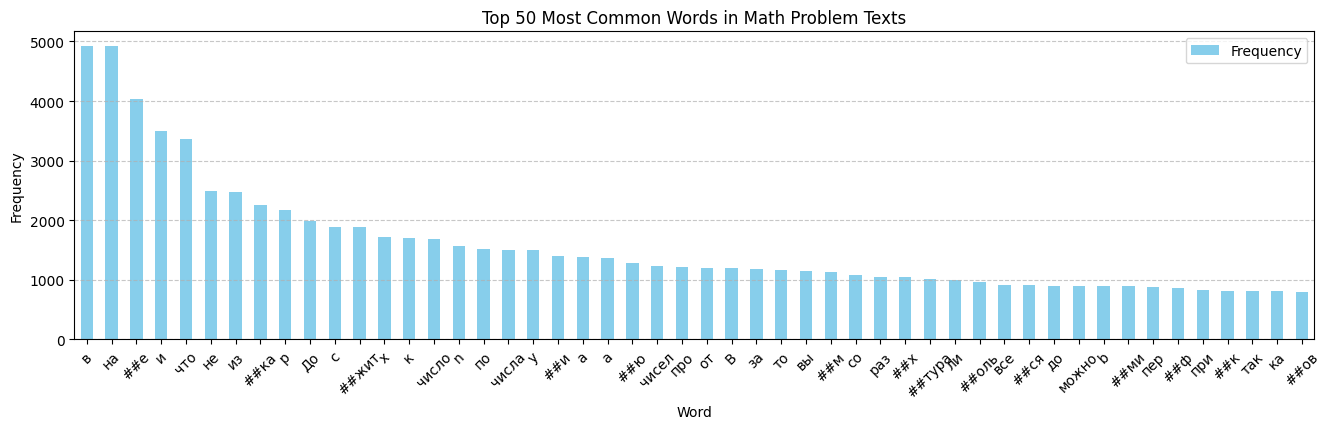

In [ ]:
all_tokens = [token for tokens_list in df_6['Tokenized_Text'] for token in tokens_list.split() if token not in ['[PAD]', '[UNK]']+list(',.!@#$%^&*()+-=?/;:1234567890[]{}<>|')]
word_freq = Counter(all_tokens)
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top N most frequent words
top_n = 50
word_freq_df.head(top_n).plot(kind='bar', figsize=(16, 4), color='skyblue')
plt.title(f'Top {top_n} Most Common Words in Math Problem Texts')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Analyze text and word len distribution

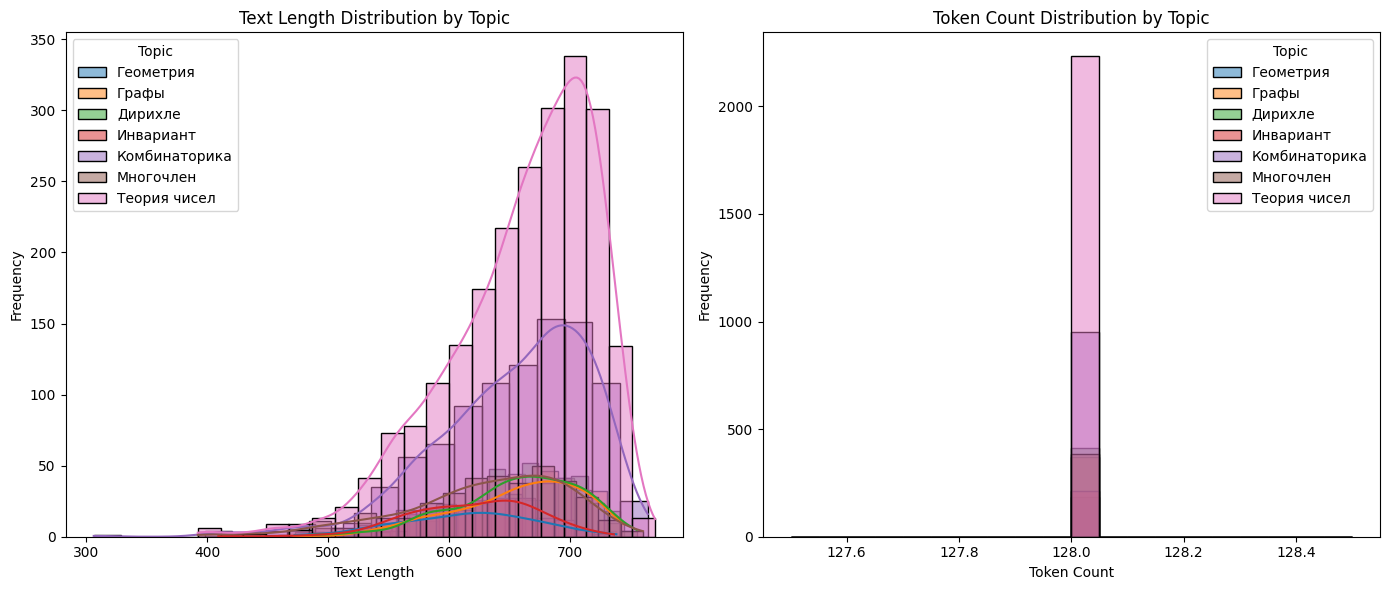

In [ ]:
df_8 = df_7.copy()
df_8['Text Length'] = df_8['Tokenized_Text'].apply(lambda x: len(x))
grouped_data = df_7.groupby('Topic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Analyze text length distribution for each topic
ax1 = plt.subplot(1, 2, 1)
for topic, data in grouped_data:
    sns.histplot(data['Text Length'], bins=20, kde=True, label=topic, ax=ax1)
ax1.set_title('Text Length Distribution by Topic')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend(title='Topic')

# Analyze word count distribution for each topic

ax2 = plt.subplot(1, 2, 2)
for topic, data in grouped_data:
    sns.histplot(data['Token_Count'], bins=20, kde=True, label=topic, ax=ax2)
ax2.set_title('Token Count Distribution by Topic')
ax2.set_xlabel('Token Count')
ax2.set_ylabel('Frequency')
ax2.legend(title='Topic')

plt.tight_layout()
plt.show()

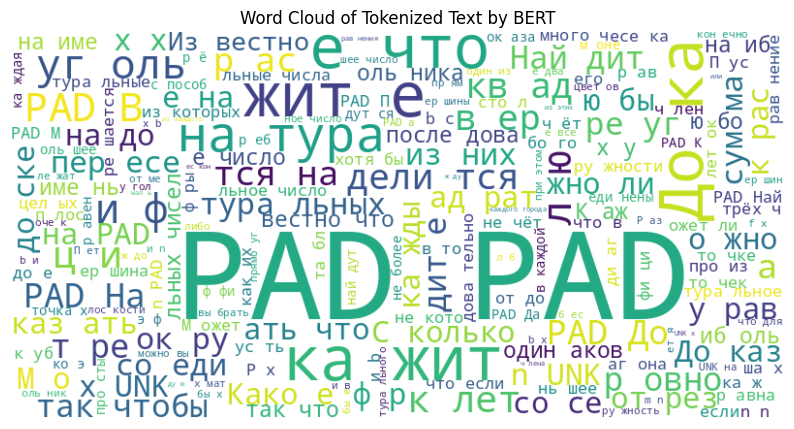

In [ ]:
flat_tokens = df_8['Tokenized_Text'].explode()
text = ' '.join(flat_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tokenized Text by BERT')
plt.axis('off')
plt.show()

###TF-IDF

We add another tokenized to get tfidf score, we dont feed nltk result to Bert since, well, Bert should get bert-tokenized input

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

df_8['Tokenized_Text_NLTK'] = df_8['Text'].apply(lambda x: word_tokenize(x))
df_8['Tokenized_Text_NLTK'] = df_8['Tokenized_Text_NLTK'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_8['Tokenized_Text_NLTK'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

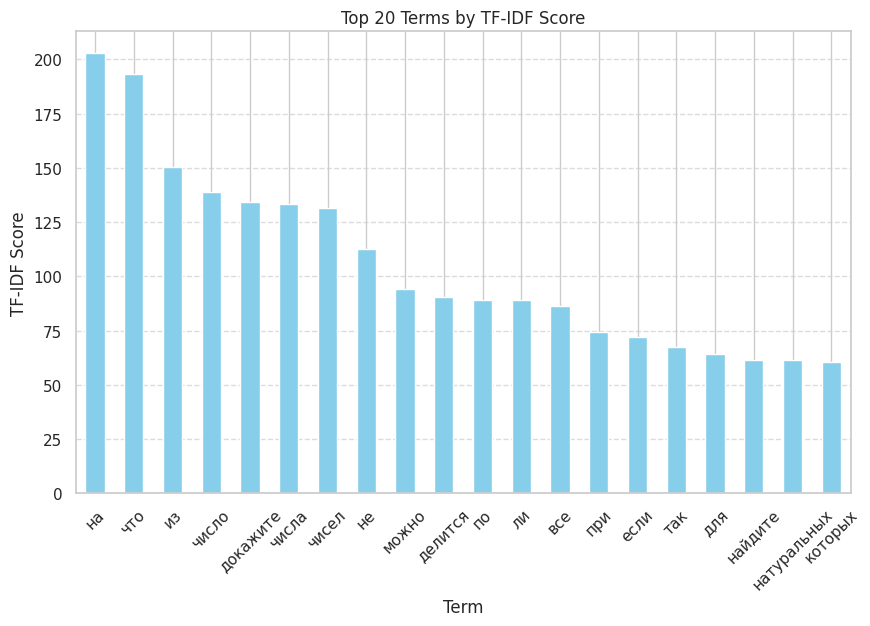

In [ ]:
tfidf_scores = tfidf_df.sum(axis=0)
sorted_terms = tfidf_scores.sort_values(ascending=False)
top_n = 20
plt.figure(figsize=(10, 6))
sorted_terms.head(top_n).plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Terms by TF-IDF Score')
plt.xlabel('Term')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

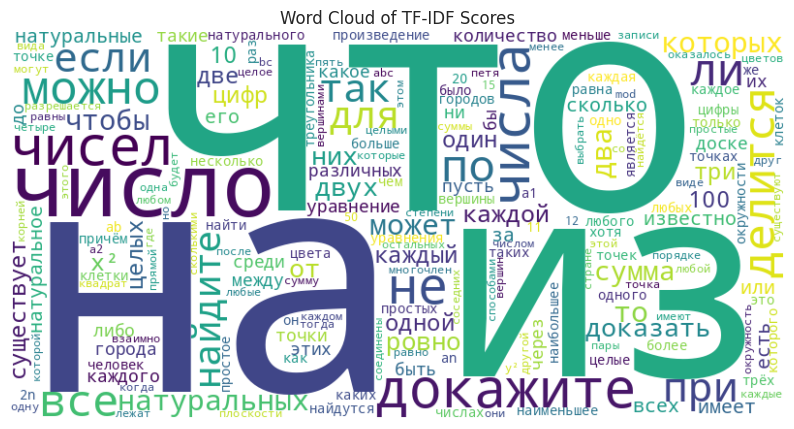

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(tfidf_scores))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of TF-IDF Scores')
plt.axis('off')
plt.show()

In [ ]:
def get_tf_idf_wordscloud(df, tokenized_how='Tokenized_Text_NLTK'):
  tfidf_scores_by_topic = {}
  tfidf_vectorizer = TfidfVectorizer()

  for topic in df['Topic'].unique():
      df_topic = df[df['Topic'] == topic]

      tfidf_matrix = tfidf_vectorizer.fit_transform(df_topic[tokenized_how])
      feature_names = tfidf_vectorizer.get_feature_names_out()
      tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()
      tfidf_dict = dict(zip(feature_names, tfidf_scores))
      tfidf_scores_by_topic[topic] = tfidf_dict


  num_topics = len(tfidf_scores_by_topic)
  num_rows = (num_topics + 2) // 3
  num_cols = min(num_topics, 3)

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
  axes = axes.flatten()

  # Create word clouds for each topic based on TF-IDF scores
  for i, (topic, tfidf_scores) in enumerate(tfidf_scores_by_topic.items()):
      wordcloud = WordCloud(width=400, height=200, background_color='white')
      wordcloud.generate_from_frequencies(tfidf_scores)

      ax = axes[i]
      ax.imshow(wordcloud, interpolation='bilinear')
      ax.set_title(f'Topic: {topic}')
      ax.axis('off')

  for i in range(num_topics, num_rows * num_cols):
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

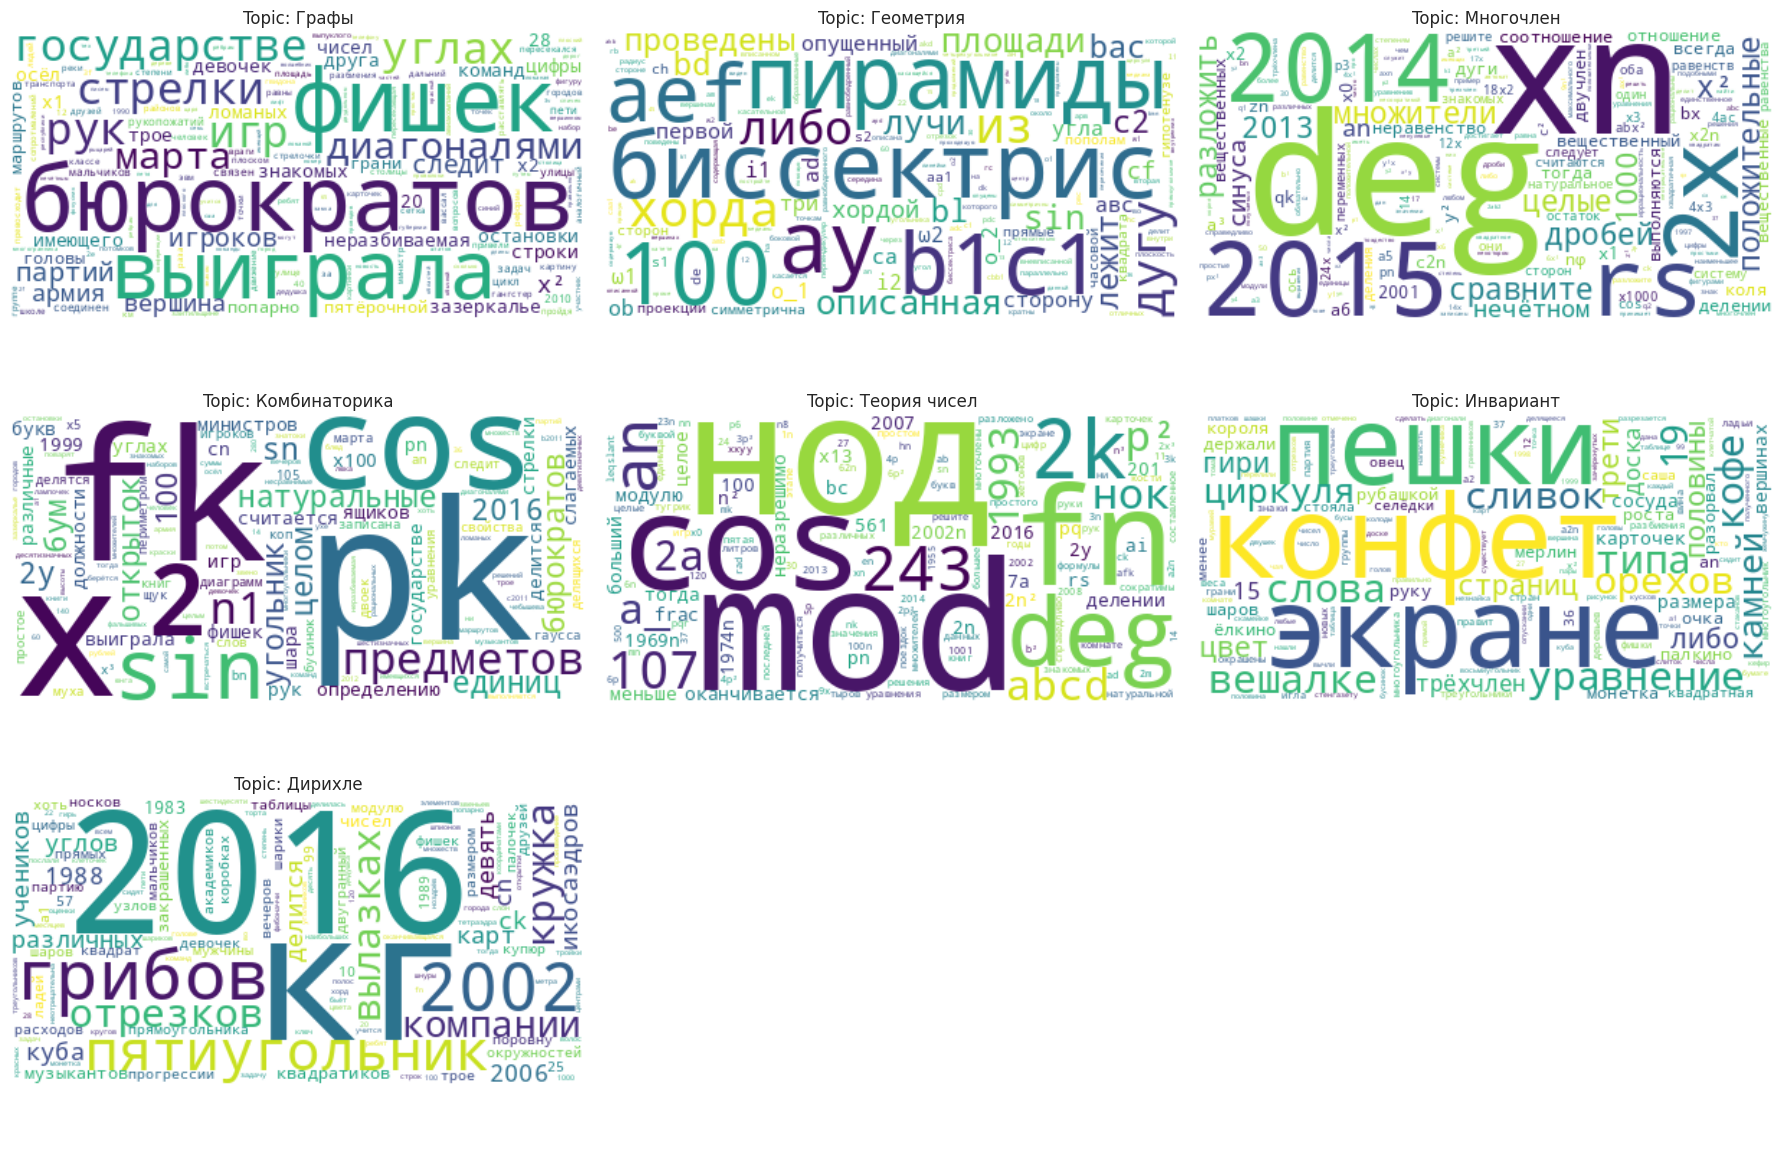

In [ ]:
get_tf_idf_wordscloud(df_8, tokenized_how='Tokenized_Text_NLTK')

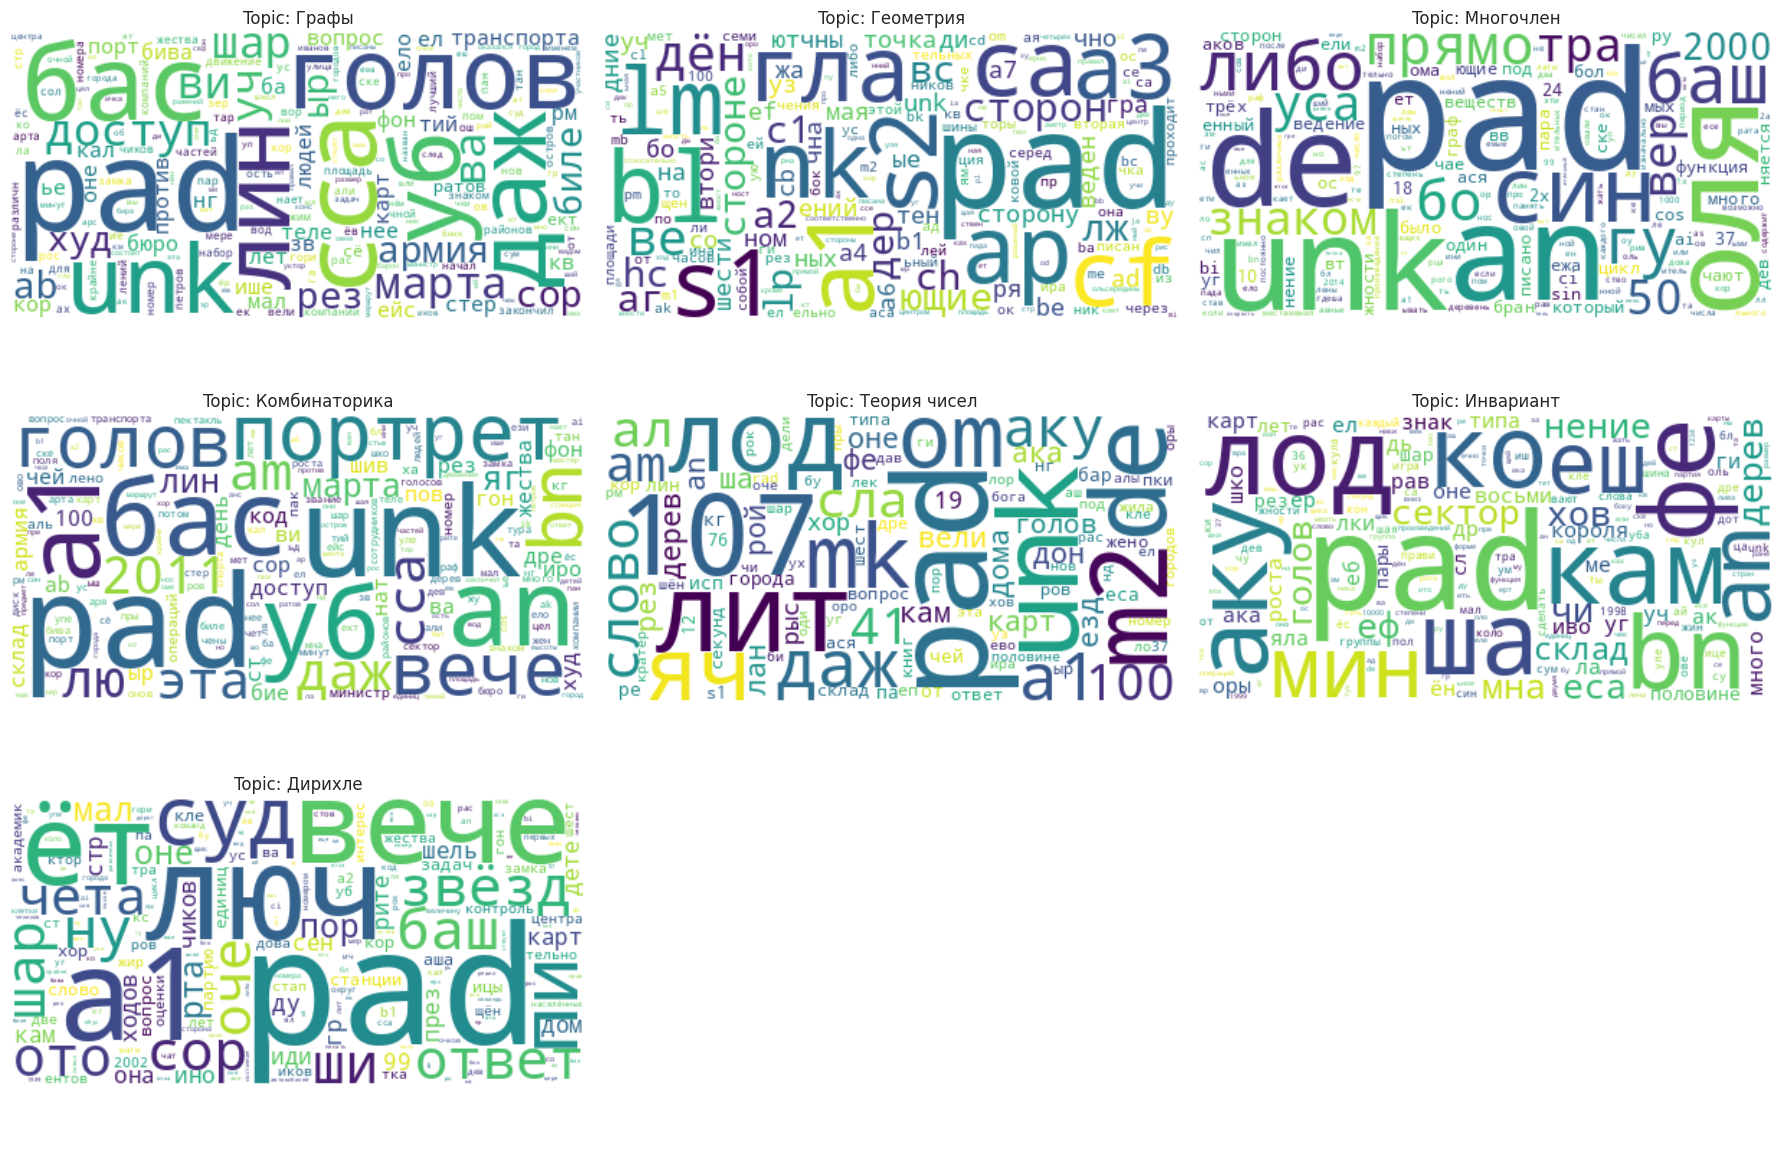

In [ ]:
get_tf_idf_wordscloud(df_8, tokenized_how='Tokenized_Text')

However since we're going to use Bert with tokenization and attention mechanism for embeddings, we don't actually need TF-IDF even as features in the df.

### Encode targets


In [ ]:
label_encoder = LabelEncoder()

In [ ]:
df_9 = df_8.copy()
df_9['Topic'] = label_encoder.fit_transform(df_9['Topic'])

### Get Bert embeddings
get model

In [ ]:
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
def get_embs(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

In [ ]:
df_10 = df_9.copy()
df_10['BERT_embeddings'] = df_10['Text'].apply(lambda x: get_embs(x, tokenizer, model))
df_10.reset_index(drop=True, inplace=True)

In [ ]:
print(df_10['BERT_embeddings'][0].shape)

(768,)



### Calculate cosine similarity between BERT embeddings

In [ ]:
def calculate_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

In [ ]:
similarities = []
for i in range(len(df_10)):
    for j in range(i+1, len(df_10)):
        similarity = calculate_similarity(df_10['BERT_embeddings'][i], df_10['BERT_embeddings'][j])
        similarities.append(similarity)

In [ ]:
print(similarities[:100])

[0.7031938, 0.598886, 0.6221453, 0.6467805, 0.6473988, 0.64486593, 0.49877173, 0.61990124, 0.639534, 0.6867901, 0.6294167, 0.6258024, 0.6060648, 0.57663536, 0.58341646, 0.63245195, 0.57798815, 0.45155495, 0.5665922, 0.5740261, 0.5892812, 0.5680166, 0.62949437, 0.52664024, 0.5559734, 0.6926786, 0.5671401, 0.62370235, 0.5548316, 0.5214317, 0.46791887, 0.58563113, 0.5124388, 0.44357836, 0.5645073, 0.5175597, 0.62662387, 0.6114563, 0.46953085, 0.65569353, 0.60831857, 0.56436634, 0.4949192, 0.63487273, 0.48988092, 0.64705014, 0.48963886, 0.6160549, 0.5858737, 0.62741333, 0.5517697, 0.6399878, 0.55452037, 0.6043867, 0.611268, 0.53814507, 0.64247435, 0.6137104, 0.57676023, 0.53134096, 0.6242839, 0.57150435, 0.61688125, 0.60406184, 0.45816097, 0.44910645, 0.6272942, 0.6695298, 0.40651637, 0.6123955, 0.5598179, 0.5508702, 0.63891995, 0.5587539, 0.5863311, 0.6199547, 0.46023864, 0.5941098, 0.6491462, 0.5898713, 0.64837295, 0.6057937, 0.62615764, 0.541922, 0.5925789, 0.6410936, 0.6174925, 0.67360

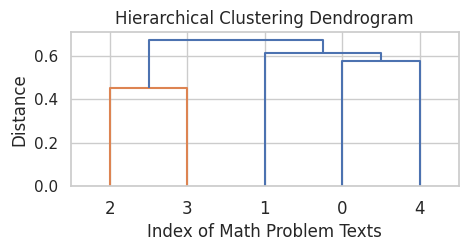

In [ ]:
Z = hierarchy.linkage(similarities[10:20], method='ward')
plt.figure(figsize=(5, 2))
dn = hierarchy.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index of Math Problem Texts')
plt.ylabel('Distance')
plt.show()

### Add translator

In [4]:
import time
class G_Translator:
  def __init__(self):
    """
    Initialize the Google Translator.
    """
    self.translator = Translator()


  def translate(self, sent: str) -> str:
    """
    Translate a sentence from Russian to English.

    :param sent: The input sentence in Russian.
    :return: The translated sentence in English.
    """
    time.sleep(0.5)
    return self.translator.translate(sent, src='ru', dest='en').text

## Unversal data preparation

In [5]:
translation = 'translation.xlsx'
processed = 'processed.xlsx'

In [6]:
def process_dataset(symbol_num=50, translate = False, preprocessed = False):
  if not preprocessed:
    dataset = pd.read_excel('data_problems.xlsx')
    df = dataset.drop(columns=['Unnamed: 0'])
    df = df.rename(columns={'Тема': 'Topic', 'Задача': 'Text'})
    df['Text Length'] = df['Text'].apply(lambda x: len(str(x)))
    df = df[~df['Text'].str.contains("Прислать комментарий") & (df['Text Length'] >= symbol_num)]
    df = df.drop_duplicates(subset=['Text'], keep='first')
    df.reset_index(drop=True, inplace=True)
    label_encoder = LabelEncoder()
    df['Topic'] = label_encoder.fit_transform(df['Topic'])
    df.to_excel(processed)
  else:
      df = pd.read_excel(processed)

  if translate:
    if os.path.exists(translation):
      df = pd.read_excel(translation)
    else:
      g = G_Translator()
      tqdm.pandas(desc="Translating:")
      df['Text'] = df['Text'].progress_apply(g.translate)
      df.to_excel(translation)
      files.download(translation)
  return df, label_encoder


def split_n_tokenize(df, tokenizer):
  train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Topic'], test_size=0.2)
  train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
  test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

  train_labels = torch.tensor(train_labels.tolist())
  test_labels = torch.tensor(test_labels.tolist())
  return train_encodings, test_encodings, train_labels, test_labels


def get_loader(train_encodings, test_encodings, train_labels, test_labels):
  train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                                torch.tensor(train_encodings['attention_mask']), train_labels)
  test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                              torch.tensor(test_encodings['attention_mask']), test_labels)

  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
  return train_loader, test_loader


def universal_preparator(tokenizer, translate=False):
  df, label_encoder = process_dataset(translate=translate)
  train_encodings, test_encodings, train_labels, test_labels = split_n_tokenize(df, tokenizer)
  train_loader, test_loader =  get_loader(train_encodings, test_encodings, train_labels, test_labels)
  return train_loader, test_loader, label_encoder

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_loader, test_loader, label_encoder = universal_preparator(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

### Add visualization

In [28]:
def plot_loss_accuracy(l_history, a_history, model_name):
    sns.set_style("darkgrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(range(1, len(l_history['train']) + 1), l_history['train'], color='blue')
    axes[0].plot(range(1, len(l_history['val']) + 1), l_history['val'], color='green')
    axes[0].set_title(model_name +' Loss History')
    axes[0].legend(['Train', 'Validation'])

    axes[1].plot(range(1, len(a_history['train']) + 1), a_history['train'], color='gold')
    axes[1].plot(range(1, len(a_history['val']) + 1), a_history['val'], color='red')
    axes[1].set_title(model_name + ' Accuracy History')
    axes[1].legend(['Train', 'Validation'])

    fig.suptitle(model_name)
    plt.show()

## Task 1 (2 points)


Write custom class for transformer model (classification, using hf model as backbone). Costructor should take as model name as input and download if from HF, then use it as backbone.

In [8]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model, num_labels: int):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = base_transformer_model
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return {"logits": logits}

### Run some date through the model

In [9]:
def model_runthrough(model, test_loader, label_encoder):
  model.eval()
  with torch.no_grad():
      for input_ids, attention_mask, labels in test_loader:
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          predictions = torch.argmax(outputs['logits'], dim=1)
          break

  predicted = label_encoder.inverse_transform(predictions.numpy())
  act_labels = label_encoder.inverse_transform(labels.numpy())

  print("Predictions:", predicted)
  print("Actual labels:", act_labels)

In [7]:
brt = BertModel.from_pretrained('bert-base-multilingual-cased')
model = TransformerClassificationModel(brt, len(label_encoder.classes_))
model_runthrough(model, test_loader, label_encoder)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Predictions: ['Геометрия' 'Геометрия' 'Геометрия' 'Геометрия' 'Геометрия' 'Геометрия'
 'Геометрия' 'Геометрия']
Actual labels: ['Теория чисел' 'Комбинаторика' 'Теория чисел' 'Геометрия' 'Комбинаторика'
 'Комбинаторика' 'Многочлен' 'Графы']


## Task 2 (1 point):

Write a func to freeze weights in backbone

In [10]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

In [ ]:
model_0 = freeze_backbone_function(model)
model_runthrough(model_0)

Predictions: ['Графы' 'Теория чисел' 'Геометрия' 'Теория чисел' 'Теория чисел'
 'Комбинаторика' 'Геометрия' 'Графы']
Actual labels: ['Теория чисел' 'Теория чисел' 'Теория чисел' 'Геометрия' 'Теория чисел'
 'Комбинаторика' 'Инвариант' 'Теория чисел']


## Task 3 (2 points):

Write a func to train the TransformerClassificationModel. The func should support training of model with frozen backbone weights

In [11]:
def log(epoch, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, h_loss, h_acc):
  print(f"Epoch {epoch}/{num_epochs}:")
  print(f"\tTrain Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
  print(f"\tValidation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
  h_loss['train'].append(train_loss)
  h_loss['val'].append(val_loss)
  h_acc['train'].append(train_accuracy)
  h_acc['val'].append(val_accuracy)
  return h_loss, h_acc

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    total_samples = len(train_loader.dataset)

    with tqdm(total=total_samples, desc=f'Train epoch {epoch}', unit=' samples', position=0, leave=True) as pbar:

      for input_ids, attention_mask, labels in train_loader:
          input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
          optimizer.zero_grad()

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          logits = outputs['logits']

          loss = criterion(logits, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          pbar.update(labels.size(0))

      return running_loss / len(train_loader)

In [13]:
def evaluate(model, data_loader, criterion, device, epoch):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    total_samples = len(data_loader.dataset)

    with torch.no_grad(), tqdm(total=total_samples, desc=f'Eval Epoch {epoch}', unit=' samples', leave=False) as pbar:
        for input_ids, attention_mask, labels in data_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(logits, labels)
            running_loss += loss.item()

            pbar.update(labels.size(0))

    accuracy = (correct / total) * 100
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

In [14]:
def epoch_loop(model, criterion, optimizer, num_epochs, train_loader, test_loader, device):
  loss_h = {'train':[], 'val':[]}
  acc_h = {'train':[], 'val':[]}
  best_val_accuracy = 0.0
  best_model = None

  with tqdm(total=num_epochs, desc='Overall Progress', unit='epoch', leave=True) as epoch_pbar:
    for epoch in range(num_epochs):
          train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1)
          train_accuracy, _ = evaluate(model, train_loader, criterion, device, epoch+1)
          val_accuracy, val_loss = evaluate(model, test_loader, criterion, device, epoch+1)

          log(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, loss_h, acc_h)
          epoch_pbar.update(1)
          if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state_dict = model.state_dict()

  if best_model is not None:
        torch.save(best_model, 'best_weights.pth')
  return model, loss_h, acc_h

In [15]:
def train_transformer(transformer_model, train_loader, test_loader, freeze_backbone=True, num_epochs=3, lr=5e-5, device='cpu'):
    model = copy.deepcopy(transformer_model)
    model.to(device)

    if freeze_backbone:
      model = freeze_backbone_function(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model, loss_h, acc_h = epoch_loop(model, criterion, optimizer, num_epochs, train_loader, test_loader, device)
    return model, loss_h, acc_h

In [ ]:
n_model, l_history, a_history = train_transformer(model, train_loader, test_loader, freeze='False')

In [ ]:
plot_loss_accuracy(l_history, a_history, 'bert multi cased')

## Task 4 (1 point):

Train *coingrated/rubert-tiny2* in two way

#### Create model loader

In [162]:
def load_model(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  train_loader, test_loader, label_encoder = universal_preparator(tokenizer)
  automodel = AutoModel.from_pretrained(name)

  model = TransformerClassificationModel(automodel, len(label_encoder.classes_))
  model_runthrough(model, test_loader, label_encoder)
  return model, train_loader, test_loader, tokenizer, label_encoder

In [165]:
model_name = 'cointegrated/rubert-tiny2'

#### Frozen weights for tiny bert

It would make much more sense to feeze all but the last attention+linear of backbone than just classifying layer

In [188]:
rubrt, rb_train_loader, rb_test_loader, rb_tokenizer, rb_label_encoder = load_model(model_name)
rbf_n_model, rbf_l_history, rbf_a_history = train_transformer(rubrt, rb_train_loader, rb_test_loader, freeze_backbone=True)

Predictions: ['Графы' 'Графы' 'Графы' 'Графы' 'Графы' 'Геометрия' 'Графы' 'Графы']
Actual labels: ['Теория чисел' 'Теория чисел' 'Геометрия' 'Комбинаторика' 'Геометрия'
 'Дирихле' 'Комбинаторика' 'Теория чисел']


Overall Progress:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 1/3:
	Train Loss: 1.8669, Accuracy: 52.97%
	Validation Loss: 1.7611, Accuracy: 53.64%


Train epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 2/3:
	Train Loss: 1.6799, Accuracy: 53.00%
	Validation Loss: 1.6072, Accuracy: 54.55%


Train epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 3/3:
	Train Loss: 1.5607, Accuracy: 53.00%
	Validation Loss: 1.5102, Accuracy: 54.94%


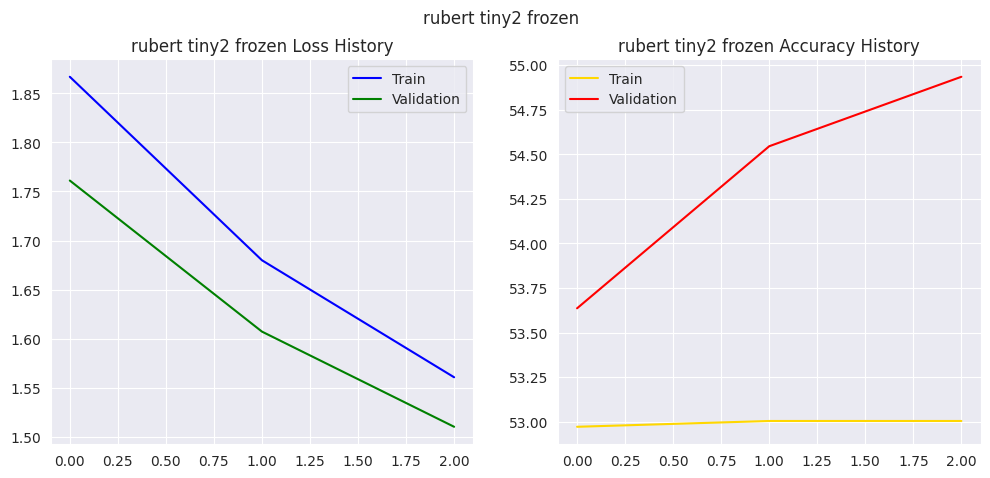

In [194]:
plot_loss_accuracy(rbf_l_history, rbf_a_history, 'rubert tiny2 frozen')

#### Unfrozen weights for tiny bert

In [185]:
rubrt2, rb_train_loader2, rb_test_loader2, rb_tokenizer2, rb_label_encoder2 = load_model(model_name)
rbnf_n_model, rbnf_l_history, rbnf_a_history = train_transformer(rubrt2, rb_train_loader2, rb_test_loader2, freeze_backbone=False)

Predictions: ['Инвариант' 'Дирихле' 'Инвариант' 'Инвариант' 'Геометрия' 'Дирихле'
 'Дирихле' 'Многочлен']
Actual labels: ['Теория чисел' 'Многочлен' 'Теория чисел' 'Теория чисел' 'Комбинаторика'
 'Теория чисел' 'Теория чисел' 'Дирихле']


Overall Progress:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 1/3:
	Train Loss: 1.0918, Accuracy: 74.11%
	Validation Loss: 0.9042, Accuracy: 68.05%


Train epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 2/3:
	Train Loss: 0.6868, Accuracy: 85.97%
	Validation Loss: 0.7602, Accuracy: 75.32%


Train epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 3/3:
	Train Loss: 0.4650, Accuracy: 93.93%
	Validation Loss: 0.7715, Accuracy: 76.10%


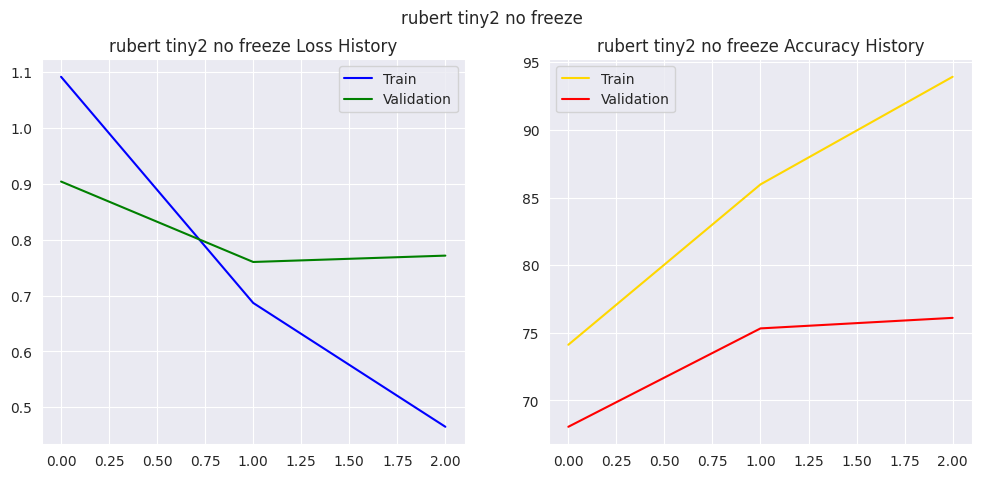

In [195]:
plot_loss_accuracy(rbnf_l_history, rbnf_a_history, 'rubert tiny2 no freeze')

## Task 5 (1 point):

Train *tbs17/MathBert* (frozen backbone and not)

Now this will suck. Since MathBert cannot tokenize russian text and the inputs of mathbert are pretty different from other models.

We either find an adapter between any russian tokenizer and MathBert or somehow replace first layers of MathBert. Or translate the dataset to English. The latter is easier so we're gonna do exactly that.

In [45]:
class MathBertClassificationModel(TransformerClassificationModel):
  def forward(self, inputs=None, attention_mask=None):
      if isinstance(inputs, dict) and 'input_ids' in inputs:
        input_ids = inputs['input_ids']
      else:
        input_ids = inputs
      print(input_ids.size())
      print(input_ids)

      outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      logits = self.classifier(pooled_output)
      return {"logits": logits}

In [35]:
def load_math_bert():
  mtokenizer = BertTokenizer.from_pretrained("tbs17/MathBERT", output_hidden_states=True)
  mmodel = BertModel.from_pretrained("tbs17/MathBERT")

  train_loader, test_loader, label_encoder = universal_preparator(mtokenizer, translate=True)

  model = MathBertClassificationModel(mmodel, len(label_encoder.classes_))
  model_runthrough(model, test_loader, label_encoder)

  n_model, l_history, a_history = train_transformer(model, train_loader, test_loader, freeze_backbone=False)
  return n_model, l_history, a_history

In [17]:

mtokenizer = BertTokenizer.from_pretrained("tbs17/MathBERT", output_hidden_states=True)
mmodel = BertModel.from_pretrained("tbs17/MathBERT")

train_loader, test_loader, label_encoder = universal_preparator(mtokenizer, translate=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
class MathBertClassificationModel(nn.Module):
    def __init__(self, backbone, num_labels):
        super(MathBertClassificationModel, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        return {"logits": logits}

#### Frozen weights for MathBert

In [76]:
ufmmodel = BertModel.from_pretrained("tbs17/MathBERT")
ufmodel = MathBertClassificationModel(ufmmodel, len(label_encoder.classes_))
model_runthrough(ufmodel, test_loader, label_encoder)

Predictions: ['Геометрия' 'Геометрия' 'Дирихле' 'Геометрия' 'Геометрия' 'Геометрия'
 'Геометрия' 'Геометрия']
Actual labels: ['Теория чисел' 'Геометрия' 'Многочлен' 'Теория чисел' 'Комбинаторика'
 'Теория чисел' 'Теория чисел' 'Теория чисел']


In [77]:
ufn_model, ml_history, ma_history = train_transformer(ufmodel, train_loader, test_loader, freeze_backbone=True, num_epochs=1, device='cuda')

Overall Progress:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 1/1:
	Train Loss: 1.5346, Accuracy: 52.58%
	Validation Loss: 1.4922, Accuracy: 50.00%


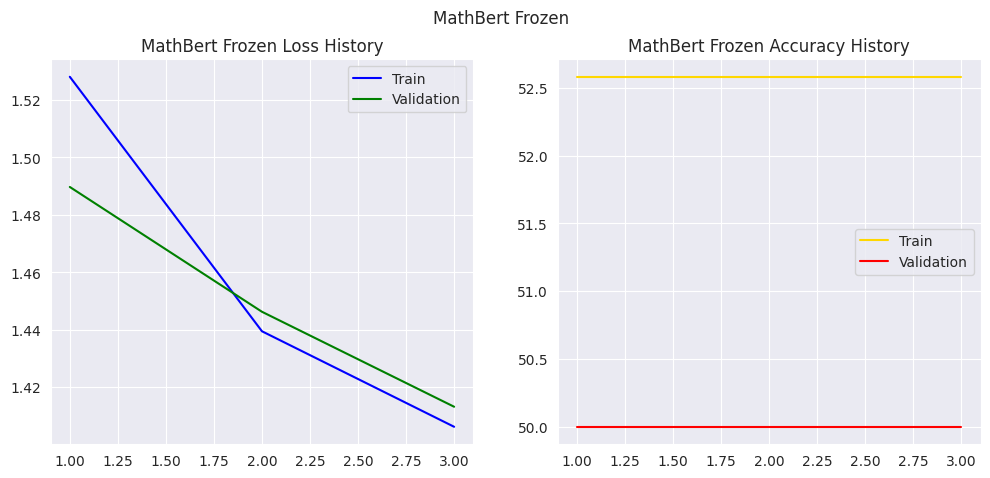

In [36]:
plot_loss_accuracy(ml_history, ma_history, 'MathBert Frozen')

It is clearly seen that the model doesn't train if we have only Classifier (well, it trains the classifier for one epoch and thats it, reaching 50% (still more than 1/7))

#### Unfrozen weights for Math Bert

In [22]:
model = MathBertClassificationModel(mmodel, len(label_encoder.classes_))
model_runthrough(model, test_loader, label_encoder)

Predictions: ['Инвариант' 'Инвариант' 'Инвариант' 'Инвариант' 'Инвариант' 'Инвариант'
 'Инвариант' 'Инвариант']
Actual labels: ['Теория чисел' 'Геометрия' 'Многочлен' 'Теория чисел' 'Комбинаторика'
 'Теория чисел' 'Теория чисел' 'Теория чисел']


In [26]:
n_model, l_history, a_history = train_transformer(model, train_loader, test_loader, freeze_backbone=False, num_epochs=8, device='cuda')

Overall Progress:   0%|          | 0/8 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 1/8:
	Train Loss: 1.0154, Accuracy: 78.76%
	Validation Loss: 0.8282, Accuracy: 70.00%


Train epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 2/8:
	Train Loss: 0.6827, Accuracy: 84.18%
	Validation Loss: 0.8907, Accuracy: 72.21%


Train epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 3/8:
	Train Loss: 0.4256, Accuracy: 96.14%
	Validation Loss: 0.8832, Accuracy: 73.51%


Train epoch 4:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 4/8:
	Train Loss: 0.2615, Accuracy: 93.34%
	Validation Loss: 1.1379, Accuracy: 68.44%


Train epoch 5:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 5/8:
	Train Loss: 0.1626, Accuracy: 95.45%
	Validation Loss: 1.2194, Accuracy: 68.70%


Train epoch 6:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 6:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 6:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 6/8:
	Train Loss: 0.1484, Accuracy: 95.91%
	Validation Loss: 1.3639, Accuracy: 66.23%


Train epoch 7:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 7:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 7:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 7/8:
	Train Loss: 0.1367, Accuracy: 98.31%
	Validation Loss: 1.3889, Accuracy: 70.65%


Train epoch 8:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 8:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 8:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 8/8:
	Train Loss: 0.1051, Accuracy: 99.16%
	Validation Loss: 1.3463, Accuracy: 72.73%


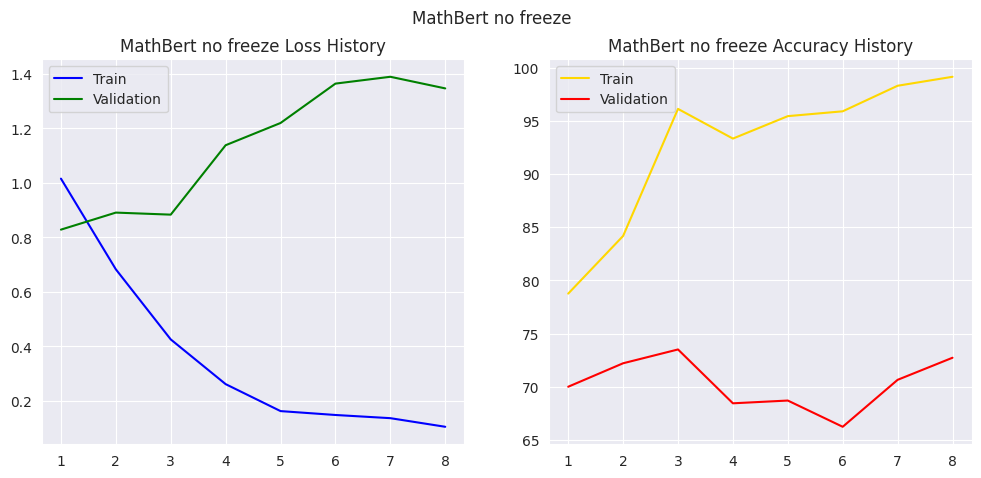

In [35]:
plot_loss_accuracy(l_history, a_history, 'MathBert no freeze')

In [30]:
torch.save(n_model.state_dict(), "mathbert.pth")
files.download('mathbert.pth')

As we can see it works much better than with frozen weights however overfit is clearly seen. Some regualrization at the classifier level might help.

For this particular case (was interested if there is any sense on a short-term run(not 100epochs) but 10 to set epochs to 8-15 instead of 2-3) so coul have written implementation of save_best_model according to validation loss\accuracy, however since in other cases there will be 3 epochs, there is no need.

#### Unfreeze only N layers AND embeddings

(just for lulz, not in the task, however i gotta do something while waiting for the mathbert weights to download)

In [ ]:
def freeze_n_layers(model, n=2):
    """
    Freeze all layers of the model except for the last n attention layers.

    Parameters:
    model (nn.Module): The transformer classification model.
    n (int): Number of layers to keep unfrozen.
    """
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last n layers
    num_layers = len(model.backbone.encoder.layer)
    for i in range(num_layers - n, num_layers):
        for param in model.backbone.encoder.layer[i].parameters():
            param.requires_grad = True

    #for param in model.backbone.embeddings.parameters():
    #      param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True
    return model


def train_mathbert_transformer(transformer_model, train_loader, test_loader, freeze_backbone=True, num_epochs=3, lr=5e-5, device='cpu'):
    model = copy.deepcopy(transformer_model)
    model.to(device)

    if freeze_backbone:
      model = freeze_n_layers(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model, loss_h, acc_h = epoch_loop(model, criterion, optimizer, num_epochs, train_loader, test_loader, device)
    return model, loss_h, acc_h

In [ ]:
funmmodel = BertModel.from_pretrained("tbs17/MathBERT")
funmodel = MathBertClassificationModel(funmmodel, len(label_encoder.classes_))

In [ ]:
n_fun_model, fun_history, fun_history = train_mathbert_transformer(funmodel, train_loader, test_loader, freeze_backbone=True, num_epochs=3, device='cuda')

Overall Progress:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 1/3:
	Train Loss: 1.0338, Accuracy: 79.70%
	Validation Loss: 0.8299, Accuracy: 70.39%


Train epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 2/3:
	Train Loss: 0.6500, Accuracy: 89.83%
	Validation Loss: 0.8023, Accuracy: 73.38%


Train epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3079 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/770 [00:00<?, ? samples/s]

Epoch 3/3:
	Train Loss: 0.3503, Accuracy: 96.78%
	Validation Loss: 0.9368, Accuracy: 71.30%


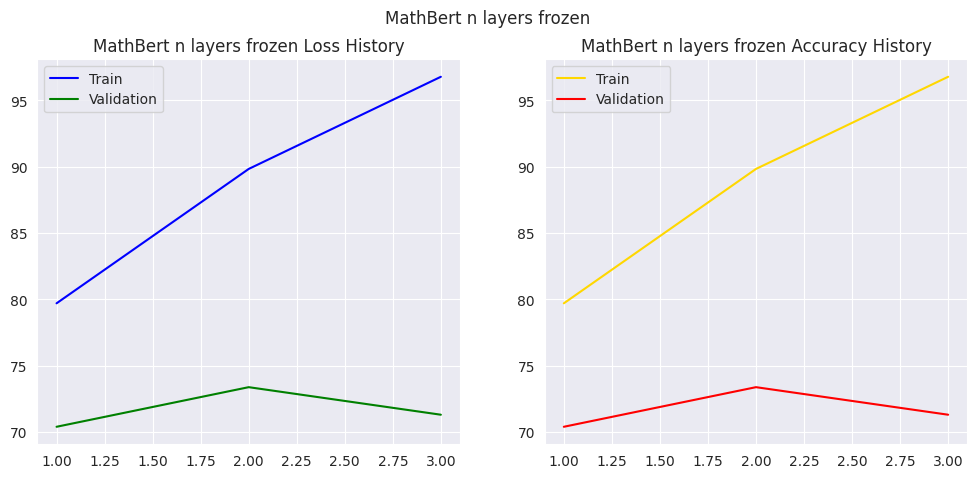

In [ ]:
plot_loss_accuracy(fun_history, fun_history, 'MathBert n layers frozen')